In [353]:
# Import needed libraries 
import pandas as pd 
import os
from datetime import timedelta
import numpy as np 
from scipy.signal import argrelextrema
import alpaca_trade_api as tradeapi 
import matplotlib.pyplot as plt 
import matplotlib.dates as mpdates
from mplfinance.original_flavor import candlestick_ohlc
from dotenv import load_dotenv

In [354]:
#Load .env environment variables
from dotenv import load_dotenv
load_dotenv()

True

In [355]:

# Set Alpaca API key and secret
ALPACA_API_KEY = os.getenv("ALPACA_API_KEY")
ALPACA_SECRET_KEY = os.getenv("ALPACA_SECRET_KEY")
ALPACA_ENDPOINT_KEY = os.getenv("ALPACA_END_POINT")

#ensuring api keys are correct 
#print(os.getenv("APCA_API_KEY_ID"))
#print(os.getenv("APCA_API_SECRET_KEY"))
#print(os.getenv("ALPACA_ENDPOINT_KEY"))

# Create the Alpaca API object
api = tradeapi.REST(ALPACA_API_KEY, ALPACA_SECRET_KEY, api_version="v2",base_url= ALPACA_ENDPOINT_KEY)

In [356]:
# Set the ticker
ticker = "QQQ"

# Set timeframe to "1 Minute"
timeframe = "5Min"

# Set start and end datetimes of 3 years from Today
start_date = pd.Timestamp("2021-01-22", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-01-23", tz="America/New_York").isoformat()

# Get 3 years worth of historical data for TSLA
ticker_data = api.get_bars(
    ticker,
    timeframe,
    start=start_date,
    end=end_date,
).df

display(ticker_data.head())
display(ticker_data.tail())

,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2021-01-22 09:00:00+00:00,325.12,325.21,325.09,46,325.21,6620,325.149352
2021-01-22 09:05:00+00:00,325.00,325.07,324.90,42,325.07,4504,324.967182
2021-01-22 09:10:00+00:00,324.95,325.04,324.94,19,325.03,4664,324.967024
2021-01-22 09:15:00+00:00,324.89,324.98,324.89,28,324.95,6945,324.909834
2021-01-22 09:20:00+00:00,324.98,325.01,324.85,23,324.89,3563,324.922919


,close,high,low,trade_count,open,volume,vwap
timestamp,,,,,,,
2021-01-22 22:35:00+00:00,325.38,325.42,325.37,70,325.41,26394,325.413173
2021-01-22 22:40:00+00:00,325.34,325.40,325.34,69,325.40,1272,325.380024
2021-01-22 22:45:00+00:00,325.32,325.42,325.32,16,325.42,50379,325.419462
2021-01-22 22:50:00+00:00,325.40,325.40,325.30,58,325.33,9575,325.358111
2021-01-22 22:55:00+00:00,325.40,325.40,325.40,10,325.40,1660,325.400000


In [357]:
#Clean up DF keep Open, High, Low, Close, Volume (OHLCV)
updated_ticker_data = ticker_data.drop(columns=['trade_count', 'vwap'])

#checking results
updated_ticker_data

,close,high,low,open,volume
timestamp,,,,,
2021-01-22 09:00:00+00:00,325.12,325.21,325.09,325.21,6620
2021-01-22 09:05:00+00:00,325.00,325.07,324.90,325.07,4504
2021-01-22 09:10:00+00:00,324.95,325.04,324.94,325.03,4664
2021-01-22 09:15:00+00:00,324.89,324.98,324.89,324.95,6945
2021-01-22 09:20:00+00:00,324.98,325.01,324.85,324.89,3563
...,...,...,...,...,...
2021-01-22 22:35:00+00:00,325.38,325.42,325.37,325.41,26394
2021-01-22 22:40:00+00:00,325.34,325.40,325.34,325.40,1272
2021-01-22 22:45:00+00:00,325.32,325.42,325.32,325.42,50379


In [358]:
# Convert the index to datetime
updated_ticker_data.index = pd.to_datetime(updated_ticker_data.index)

In [359]:
# Isolate closing prices to use for plotting stock data
close = updated_ticker_data['close']

/Users/etienne/anaconda3/envs/machine_learning/lib/python3.10/site-packages/numpy/lib/polynomial.py:666: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/Users/etienne/anaconda3/envs/machine_learning/lib/python3.10/site-packages/numpy/core/_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/etienne/anaconda3/envs/machine_learning/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3526: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


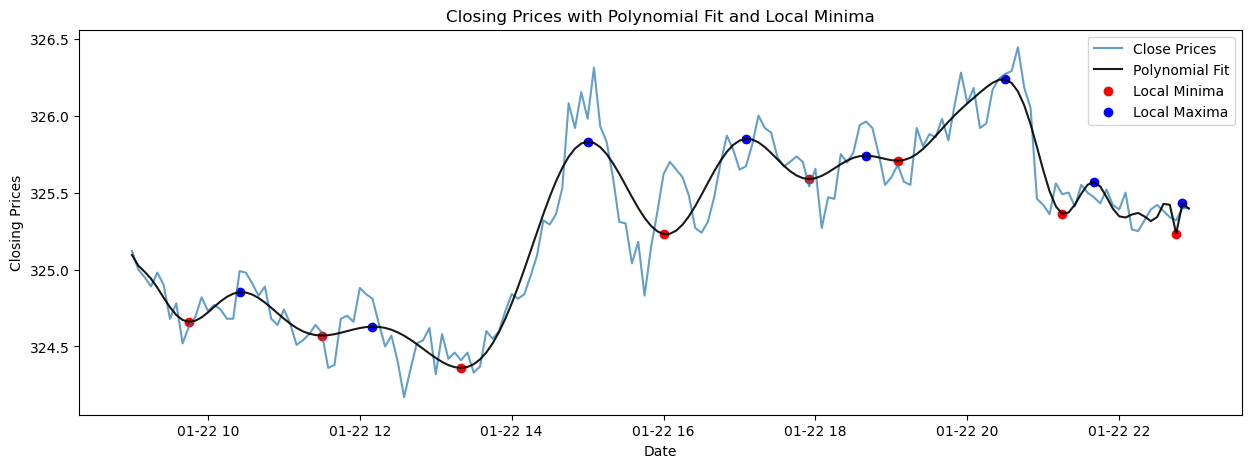

In [360]:
# Plot the stock data, polynomial fit, and local minima
plt.figure(figsize=(15, 5))

# Plot the close prices
min_length = min(len(updated_ticker_data.index), len(updated_ticker_data['close']))
plt.plot(updated_ticker_data.index[:min_length], updated_ticker_data['close'][:min_length], label='Close Prices', alpha=0.7)

# Polynomial fit

# Establish x-axis
x_data = np.arange(min_length)
# Identify degree of polynomial, can be adjusted at a later date
polynomial_degree = 75
# Calculate the polynomial coefficients to fit the stock data chart
polynomial_coefficients = np.polyfit(x_data, updated_ticker_data['close'][:min_length], polynomial_degree)
# evaluates the polynomial for plotting
y_polynomial = np.polyval(polynomial_coefficients, x_data)

# Plot the polynomial fit
plt.plot(updated_ticker_data.index[:min_length], y_polynomial, '-', markersize=1.0, color='black', alpha=0.9, label='Polynomial Fit')

# Find local minima indices using scipy's argrelextrema
minima_indices = argrelextrema(updated_ticker_data.values[:min_length], np.less, order=5)[0]

# Plot red dots at local minima
plt.scatter(updated_ticker_data.index[local_poly_minima], y_polynomial[local_poly_minima], color='red', label='Local Minima')

# Find local maxima indices
maxima_indices = argrelextrema(updated_ticker_data.values[:min_length], np.greater, order=5)[0]

# Plot blue dots at local maxima
plt.scatter(updated_ticker_data.index[local_poly_maxima],y_polynomial[local_poly_maxima], color="blue", label = "Local Maxima")

# Plot red dots at local minima
#plt.scatter(updated_ticker_data.index[minima_indices], updated_ticker_data['close'].iloc[minima_indices], color='red', label='Local Minima')

# Plot Parameters
plt.title('Closing Prices with Polynomial Fit and Local Minima')
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.legend()
plt.show()

In [361]:
# local_poly_minima = argrelextrema(y_polynomial, np.less, order=5)[0]

# # Plot polynomial fit
# plt.plot(updated_ticker_data.index[:min_length], y_polynomial, '-', markersize=1.0, color='black', alpha=0.9, label='Polynomial Fit')

# # Plot red dots at local minima
# plt.scatter(updated_ticker_data.index[local_poly_minima], y_polynomial[local_poly_minima], color='red', label='Local Minima')

In [362]:
# # Plot the stock data, polynomial fit, and local minima and maxima
# plt.figure(figsize=(15, 5))

# # Plot the close prices
# min_length = min(len(updated_ticker_data.index), len(updated_ticker_data['close']))
# plt.plot(updated_ticker_data.index[:min_length], updated_ticker_data['close'][:min_length], label='Close Prices', alpha=0.7)

# # Polynomial fit
# x_data = np.arange(min_length)
# polynomial_degree = 100  # Adjust as needed
# polynomial_coefficients = np.polyfit(x_data, updated_ticker_data['close'][:min_length], polynomial_degree)
# y_polynomial = np.polyval(polynomial_coefficients, x_data)

# # Plot the polynomial fit
# plt.plot(updated_ticker_data.index[:min_length], y_polynomial, '-', markersize=1.0, color='black', alpha=0.9, label='Polynomial Fit')

# # Find local maxima indices using scipy's argrelextrema
# maxima_indices = argrelextrema(updated_ticker_data['close'].values[:min_length], np.greater, order=5)[0]

# # Plot blue dots at local maxima
# plt.scatter(updated_ticker_data.index[maxima_indices], updated_ticker_data['close'].iloc[maxima_indices], color='blue', label='Local Maxima')

# plt.title('Closing Prices with Polynomial Fit and Local Maxima')
# plt.xlabel('Date')
# plt.ylabel('Closing Prices')
# plt.legend()
# plt.show()

In [363]:
# local_poly_maxima = argrelextrema(y_polynomial, np.greater, order=5)[0]

# # Plot polynomial fit
# plt.plot(updated_ticker_data.index[:min_length], y_polynomial, '-', markersize=1.0, color='black', alpha=0.9, label='Polynomial Fit')

# plt.scatter(updated_ticker_data.index[local_poly_maxima],y_polynomial[local_poly_maxima], color="blue", label = "Local Maxima")

In [364]:
# Convert the polynomial fit data into a dataframe
poly_df = pd.DataFrame(y_polynomial)
columns = ['poly_fit']
poly_df.columns = columns
poly_df.head()

,poly_fit
0,325.094530
1,325.025282
2,324.985643
3,324.940440
4,324.882327


In [365]:
# Reset the index of the original updated ticker dataframe to concat with the polynomial dataframe that does not include a timeseries
# This will ensure that the indexed intergers of the ploynomial fit align with the time each data point corresponds to 
updated_ticker_data = updated_ticker_data.reset_index()
updated_ticker_data = pd.concat([updated_ticker_data, poly_df], axis='columns', join='inner')
updated_ticker_data

,timestamp,close,high,low,open,volume,poly_fit
0,2021-01-22 09:00:00+00:00,325.12,325.21,325.09,325.21,6620,325.094530
1,2021-01-22 09:05:00+00:00,325.00,325.07,324.90,325.07,4504,325.025282
2,2021-01-22 09:10:00+00:00,324.95,325.04,324.94,325.03,4664,324.985643
3,2021-01-22 09:15:00+00:00,324.89,324.98,324.89,324.95,6945,324.940440
4,2021-01-22 09:20:00+00:00,324.98,325.01,324.85,324.89,3563,324.882327
...,...,...,...,...,...,...,...
163,2021-01-22 22:35:00+00:00,325.38,325.42,325.37,325.41,26394,325.426698
164,2021-01-22 22:40:00+00:00,325.34,325.40,325.34,325.40,1272,325.420695
165,2021-01-22 22:45:00+00:00,325.32,325.42,325.32,325.42,50379,325.234141
166,2021-01-22 22:50:00+00:00,325.40,325.40,325.30,325.33,9575,325.430174


In [366]:
# Add 'minima' column to the DataFrame
updated_ticker_data['minima'] = 0  # Initialize 'minima' column with zeros

# Mark rows with local minima as 1 in the 'minima' column
for index in minima_indices:
    updated_ticker_data.at[index, 'minima'] = 1

updated_ticker_data.head(50)

,timestamp,close,high,low,open,volume,poly_fit,minima
0,2021-01-22 09:00:00+00:00,325.12,325.21,325.09,325.21,6620,325.094530,0
1,2021-01-22 09:05:00+00:00,325.00,325.07,324.90,325.07,4504,325.025282,0
2,2021-01-22 09:10:00+00:00,324.95,325.04,324.94,325.03,4664,324.985643,0
3,2021-01-22 09:15:00+00:00,324.89,324.98,324.89,324.95,6945,324.940440,0
4,2021-01-22 09:20:00+00:00,324.98,325.01,324.85,324.89,3563,324.882327,0
5,2021-01-22 09:25:00+00:00,324.90,325.00,324.90,325.00,5496,324.817113,0
6,2021-01-22 09:30:00+00:00,324.68,324.93,324.56,324.91,5056,324.754777,0
7,2021-01-22 09:35:00+00:00,324.78,324.78,324.58,324.58,3851,324.704463,0
8,2021-01-22 09:40:00+00:00,324.52,324.74,324.52,324.74,1993,324.672151,1
9,2021-01-22 09:45:00+00:00,324.63,324.63,324.42,324.53,9402,324.660040,1


In [367]:
# Add 'maxima' column to the DataFrame
updated_ticker_data['maxima'] = 0  # Initialize 'maxima' column with zeros

# Mark rows with local minima as 1 in the 'minima' column
for index in maxima_indices:
    updated_ticker_data.at[index, 'maxima'] = 1

updated_ticker_data.head(50)

,timestamp,close,high,low,open,volume,poly_fit,minima,maxima
0,2021-01-22 09:00:00+00:00,325.12,325.21,325.09,325.21,6620,325.094530,0,0
1,2021-01-22 09:05:00+00:00,325.00,325.07,324.90,325.07,4504,325.025282,0,0
2,2021-01-22 09:10:00+00:00,324.95,325.04,324.94,325.03,4664,324.985643,0,0
3,2021-01-22 09:15:00+00:00,324.89,324.98,324.89,324.95,6945,324.940440,0,1
4,2021-01-22 09:20:00+00:00,324.98,325.01,324.85,324.89,3563,324.882327,0,0
5,2021-01-22 09:25:00+00:00,324.90,325.00,324.90,325.00,5496,324.817113,0,0
6,2021-01-22 09:30:00+00:00,324.68,324.93,324.56,324.91,5056,324.754777,0,0
7,2021-01-22 09:35:00+00:00,324.78,324.78,324.58,324.58,3851,324.704463,0,0
8,2021-01-22 09:40:00+00:00,324.52,324.74,324.52,324.74,1993,324.672151,1,0
9,2021-01-22 09:45:00+00:00,324.63,324.63,324.42,324.53,9402,324.660040,1,1
